In [1]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=30,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=30,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5).to(device)
        self.pool = nn.MaxPool2d(2, 2).to(device)
        self.conv2 = nn.Conv2d(6, 16, 5).to(device)
        self.fc1 = nn.Linear(16 * 5 * 5, 120).to(device)
        self.fc2 = nn.Linear(120, 84).to(device)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))).to(device)
        x = self.pool(F.relu(self.conv2(x))).to(device)
        x = x.view(-1, 16 * 5 * 5).to(device)  # to flatten the input that is fed to fc layers  (alternatively, reshape and flatten can be used)
        x = F.relu(self.fc1(x)).to(device)
        x = F.relu(self.fc2(x)).to(device)
        x = F.relu(self.fc3(x)).to(device)
        #x = F.softmax(x, dim=1).to(device)
        return x

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

cuda:0
Finished Training


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def img_show(img):
    img = img / 2 + 0.5  # un-normalize (mean = 0.5, std = 0.5)
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

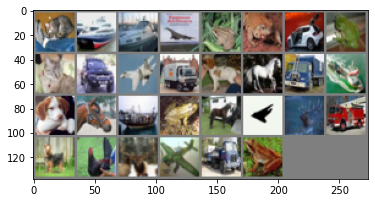

GroundTruth:    cat  ship  ship plane
Predicted:    dog  ship plane  ship
Accuracy of the network on the 10000 test images: 56 %
Accuracy of plane : 67 %
Accuracy of   car : 74 %
Accuracy of  bird : 50 %
Accuracy of   cat :  0 %
Accuracy of  deer : 47 %
Accuracy of   dog : 73 %
Accuracy of  frog : 76 %
Accuracy of horse : 67 %
Accuracy of  ship : 69 %
Accuracy of truck : 52 %


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)
# print images
img_show(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net.load_state_dict(torch.load(PATH))
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
            100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(9):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [29]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
from PIL import Image

def inversion(model, image, label):
  iteration = 1000
  input = Variable(image.cuda(), requires_grad=True)
  model.zero_grad()
  for i in range(iteration):
    out = model(input[None, ...].float())
    loss = out.take(label)
    loss.backward()

    input.data = input.data - 0.1 * input.grad.data
    input.grad.zero_()
  input = input.data.squeeze()
  input.transpose_(0,1)
  input.transpose_(1,2)
  input = np.clip(input.cpu(), 0, 1)
  reconstructed_image = Image.fromarray(np.uint8(input*255))
  plt.imshow(reconstructed_image)



Actual Image


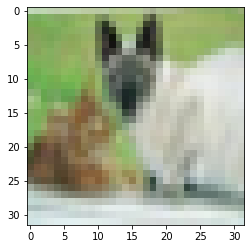

Reconstructed Image


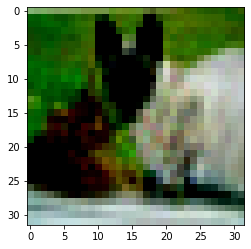

In [31]:
testdata_iter = iter(testloader)
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

image = images[1]
label = labels[1]

model = Net()
print("Actual Image")
img_show(image.cpu())
print("Reconstructed Image")
inversion(model.to(device), image, label)
